In [1]:
%run UNet.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from typing import Tuple, Optional, List
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import torchvision
from labml_helpers.device import DeviceConfigs
from labml.configs import BaseConfigs, option
from labml import lab, tracker, experiment, monit
from PIL import Image


In [3]:
def gather(consts, t):
  c = consts.gather(-1, t)
  return c.reshape(-1, 1, 1, 1)

In [4]:
class DDPM:
  def __init__(self, eps, steps, device):
    super().__init__()
    self.eps = eps
    self.steps = steps
    self.beta = torch.linspace(0.0001, 0.02, steps).to(device)
    self.alpha = 1 - self.beta
    self.alpha_bar = torch.cumprod(self.alpha, dim = 0)
    self.sigma_2 = self.beta

  def q_xt_given_x0(self, x0, t):
    mean = gather(self.alpha_bar, t) ** 0.5 * x0
    variance = 1 - gather(self.alpha_bar, t)
    return mean, variance

  def sample_from_q(self, x0, t, eps):
    if eps is None:
      eps = torch.randn_like(x0)
    mean, variance = self.q_xt_given_x0(x0, t)
    return mean + (variance ** 0.5) * eps

  def sample_from_p(self, xt, t):
    eps = self.eps(xt, t)
    alpha_bar = gather(self.alpha_bar, t)
    alpha = gather(self.alpha, t)
    beta = 1 - alpha
    coefficient = beta / (1 - alpha_bar) ** 0.5
    mean = ((1 / alpha) ** 0.5) * (xt - coefficient * eps)
    variance = gather(self.sigma_2, t)
    eps_ = torch.randn(xt.shape, device = xt.device)
    return mean + (variance ** 0.5) * eps_

  def loss(self, x0, noise: Optional[torch.Tensor] = None):
    batch_size = x0.shape[0]
    t = torch.randint(0, self.steps, (batch_size,), device = x0.device, dtype = torch.long)
    if noise is None:
      noise = torch.randn_like(x0)
    xt = self.sample_from_q(x0, t, noise)
    eps_model = self.eps(xt, t)
    return F.mse_loss(noise, eps_model)

In [5]:
import numpy as np
class Configs(BaseConfigs):
    device: torch.device = DeviceConfigs()
    eps_model: UNet
    diffusion: DDPM
    image_channels: int = 1
    image_size: int = 32
    n_channels: int = 64
    channel_multipliers: List[int] = [1, 2, 2, 4]
    is_attention: List[int] = [False, False, False, True]
    n_steps: int = 1_000
    batch_size: int = 64
    n_samples: int = 16
    learning_rate: float = 2e-5
    epochs: int = 1_000
    dataset: torch.utils.data.Dataset
    data_loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Adam

    def init(self):
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        self.diffusion = DDPM(
            eps=self.eps_model,
            steps=self.n_steps,
            device=self.device,
        )
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)
        tracker.set_image("sample", True)

    def sample(self):
        with torch.no_grad():
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)
            for t_ in monit.iterate('Sample', self.n_steps):
                t = self.n_steps - t_ - 1
                x = self.diffusion.sample_from_p(x, x.new_full((self.n_samples,), t, dtype=torch.long))
            tracker.save('sample', x)

    def train(self):
        for data in monit.iterate('Train', self.data_loader):
            tracker.add_global_step()
            data = data.to(self.device)
            self.optimizer.zero_grad()
            loss = self.diffusion.loss(data)
            loss.backward()
            self.optimizer.step()
            tracker.save('loss', loss)

    def run(self):
        for _ in monit.loop(self.epochs):
            self.train()
            self.sample()
            tracker.new_line()
            experiment.save_checkpoint()


In [6]:
class MNISTDataset(torchvision.datasets.MNIST):
  def __init__(self, image_size):
    transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])
    super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)
  def __getitem__(self, item):
    return super().__getitem__(item)[0]

@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
  return MNISTDataset(c.image_size)

In [12]:
def main():
  experiment.create(name='diffusion training')
  configs = Configs()
  experiment.configs(configs, {
      'dataset': 'MNIST',
      'image_channels': 1,
      'epochs': 10
  })
  configs.init()
  experiment.add_pytorch_models({'eps_model': configs.eps_model})
  with experiment.start():
    configs.run()

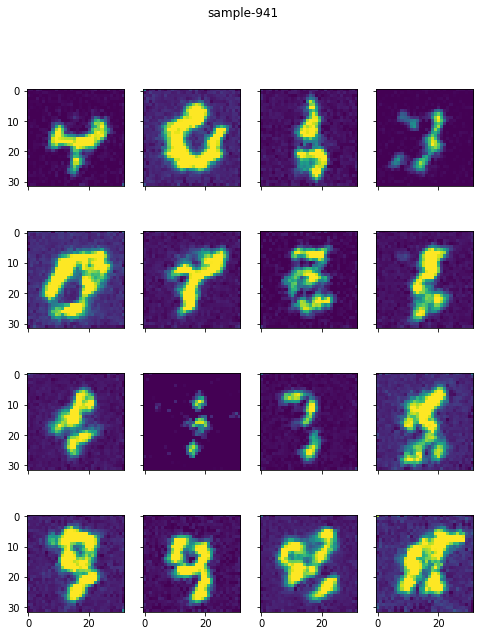

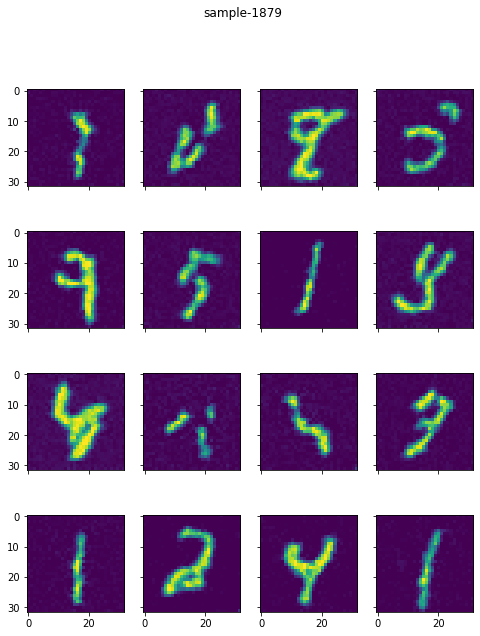

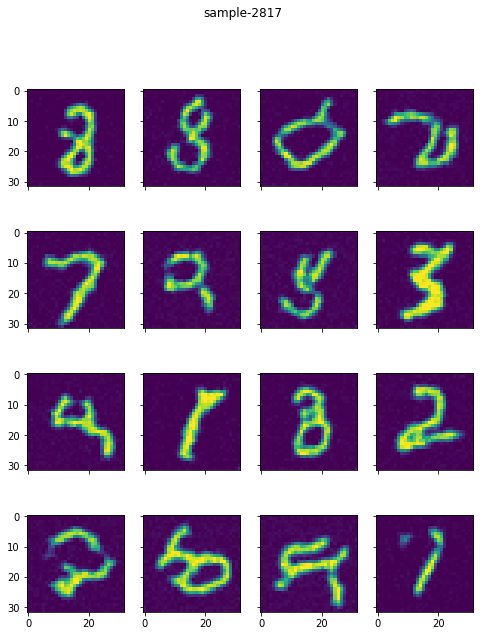

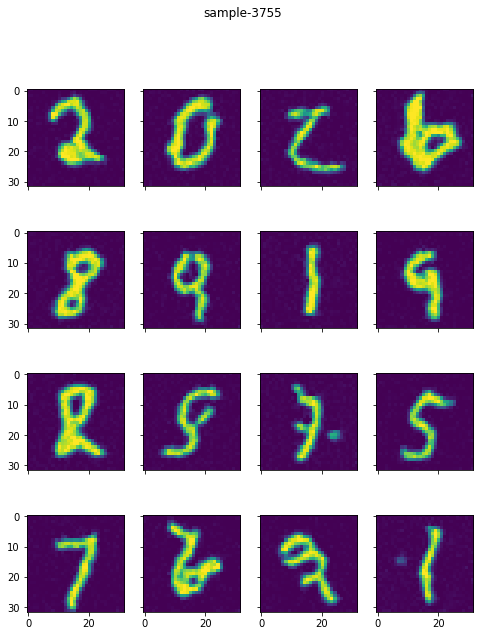

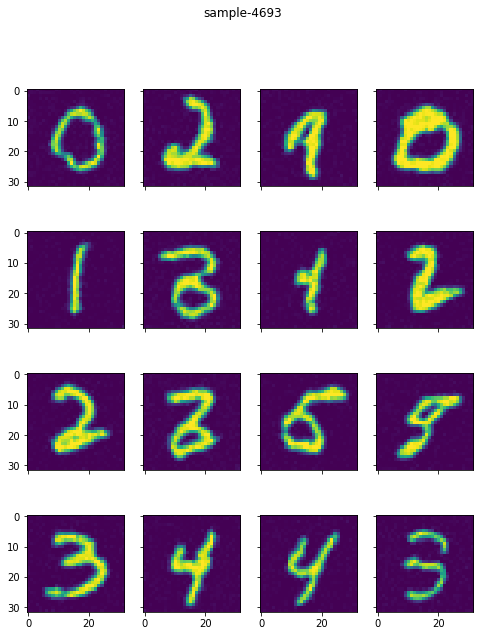

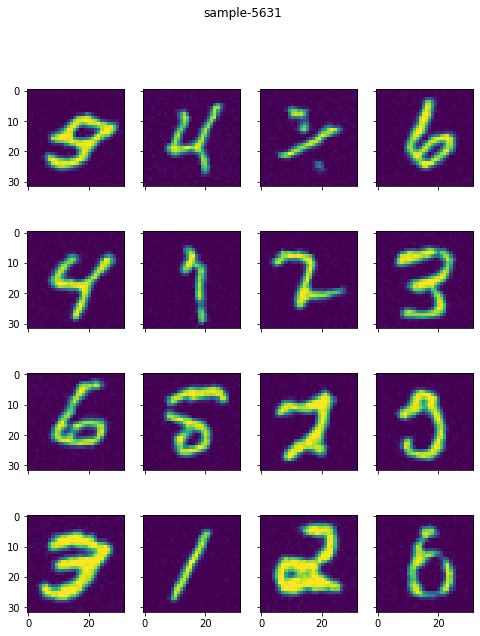

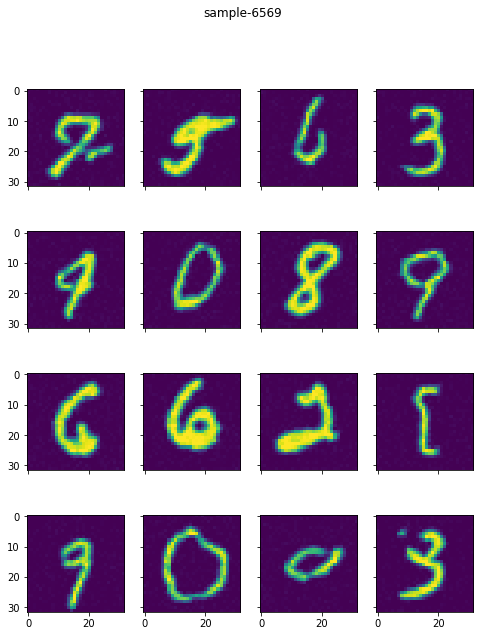

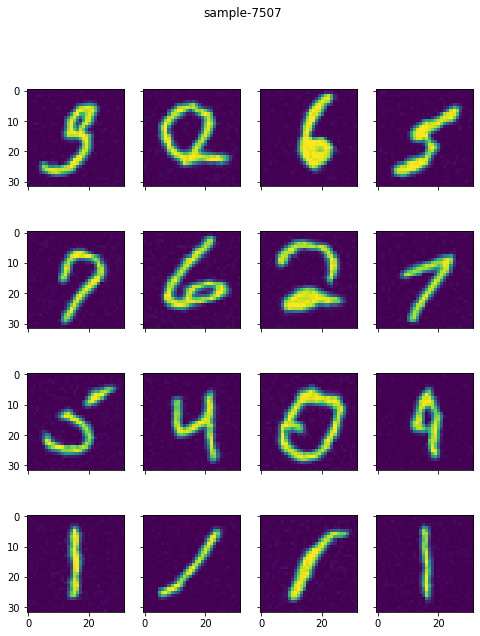

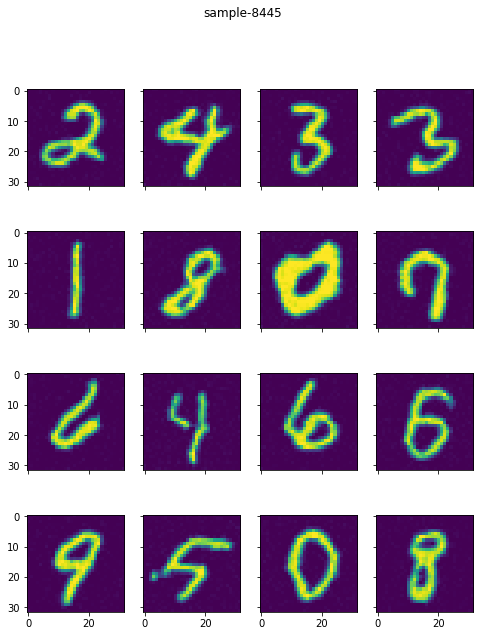

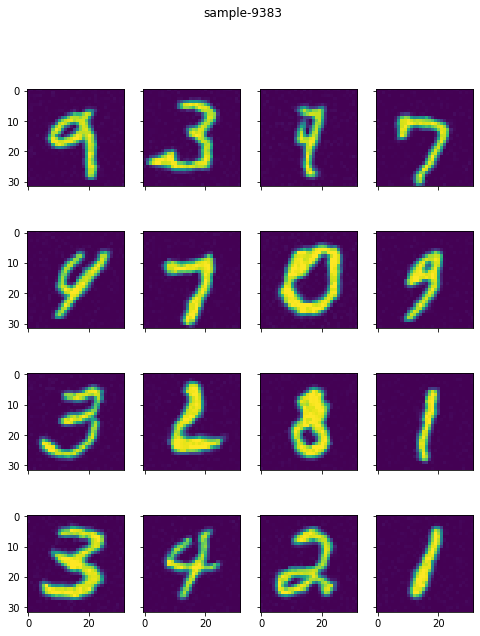

In [14]:
if __name__ == '__main__':
  main()